In [1]:
import numpy as np
import pandas as pd
import os
import gym
import random
from gym import spaces
import torch
import matplotlib.pyplot as plt
from Environment import DiagnosisEnv
from Agent import train_DQN

In [2]:
df_symptoms = pd.read_csv("Data/Symptoms.csv")
df_exams = pd.read_csv("Data/Examinations.csv")
df_emergency_diagnoses = pd.read_csv("Data/Emergency_Diagnosis.csv")
df_gen_surgery_diagnoses = pd.read_csv("Data/Gen_Surgery_Diagnosis.csv")
df_neuro_diagnoses = pd.read_csv("Data/Neuro_Diagnosis.csv")

In [3]:
df_combined = pd.concat([df_emergency_diagnoses,df_gen_surgery_diagnoses,df_neuro_diagnoses])

In [4]:
env = DiagnosisEnv(df_symptoms, df_exams, df_combined)
agent, rewards, success_rates, examinations_per_diagnosis = train_DQN(env, episodes=5000)

C:\Users\jerem\Project_Hospital\Agent.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return (torch.tensor(state, dtype=torch.float32),


In [5]:
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

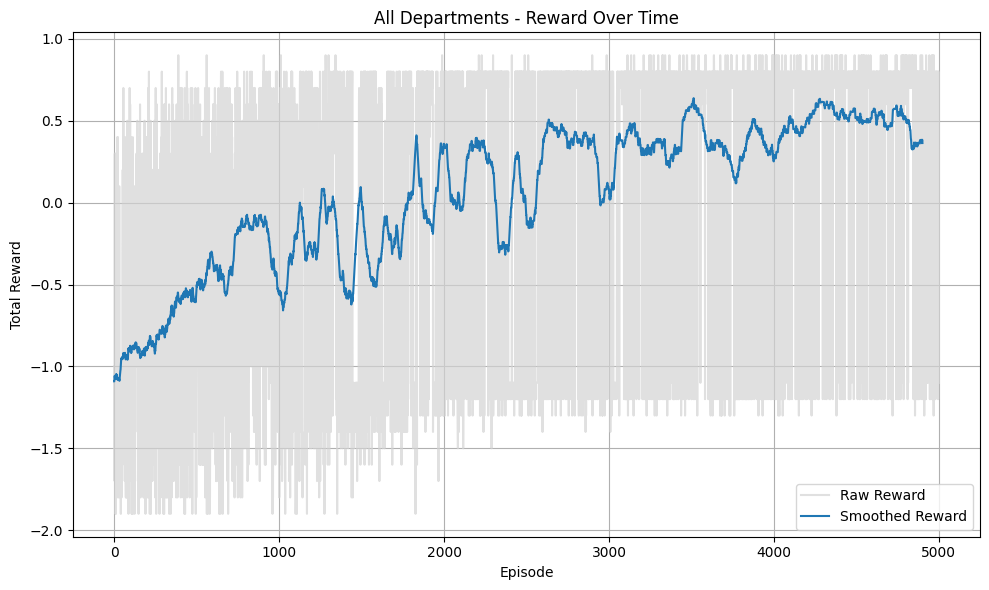

In [6]:
smoothed_rewards = moving_average(rewards, window_size=100)
plt.figure(figsize=(10,6))
plt.plot(rewards, color="lightgray", label="Raw Reward", alpha=0.7)
plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label="Smoothed Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("All Departments - Reward Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

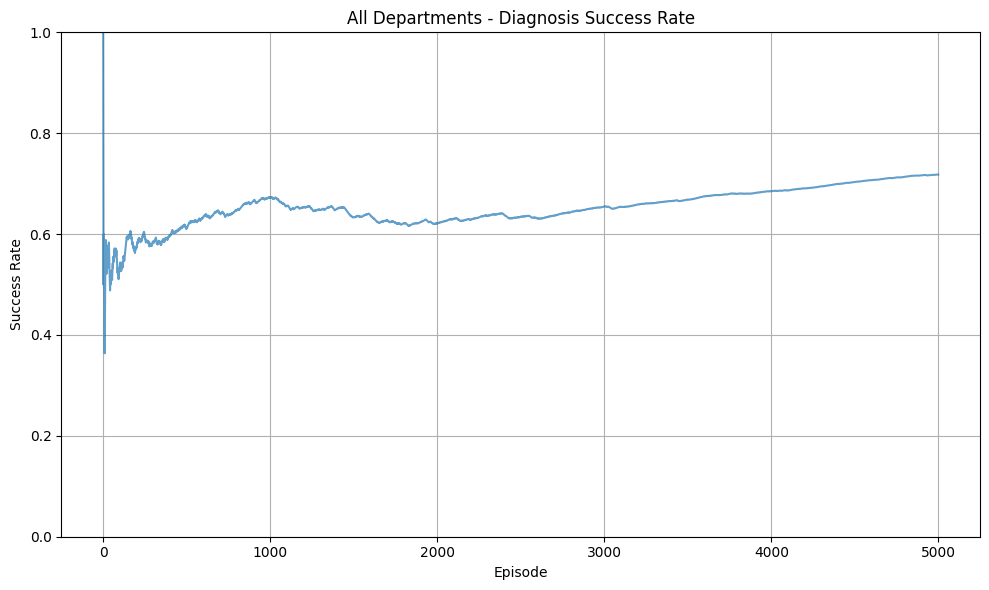

In [7]:
plt.figure(figsize=(10,6))
plt.plot(success_rates, alpha=0.7)
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.title("All Departments - Diagnosis Success Rate")
plt.ylim(0,1)
plt.grid(True)
plt.tight_layout()
plt.show()

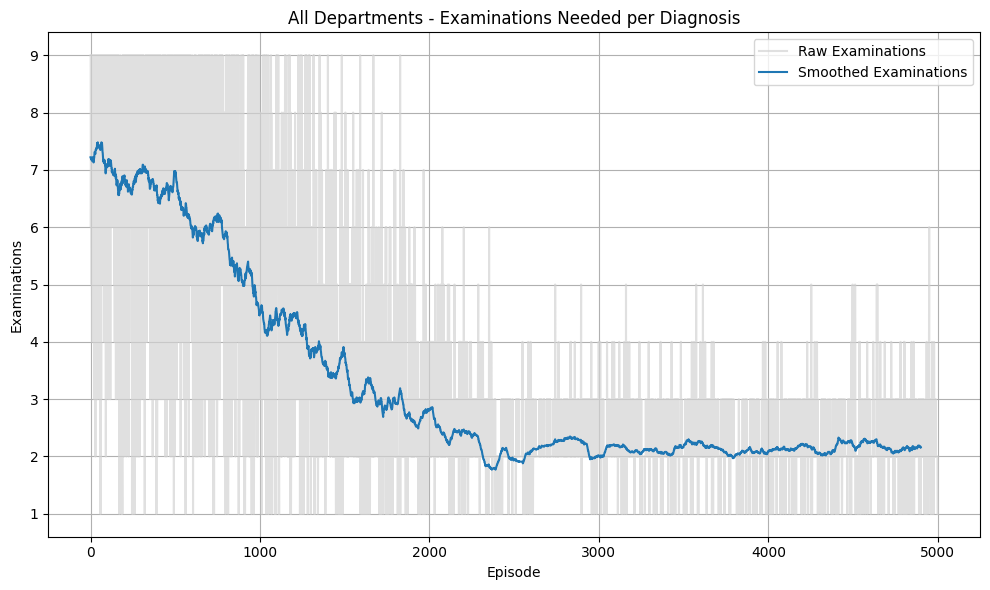

In [8]:
smoothed_examinations = moving_average(examinations_per_diagnosis, window_size=100)
plt.figure(figsize=(10,6))
plt.plot(examinations_per_diagnosis, color="lightgray", label="Raw Examinations", alpha=0.7)
plt.plot(range(len(smoothed_examinations)), smoothed_examinations, label="Smoothed Examinations")
plt.xlabel("Episode")
plt.ylabel("Examinations")
plt.title("All Departments - Examinations Needed per Diagnosis")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
df_combined = df_combined.reset_index(drop=True)
def test_agent(env, agent, num_patients=10):
    number_of_diagnoses = len(df_combined)
    print("All Departments, Number of possible Diagnosis: " + str(number_of_diagnoses))
    overall_correct_diagnoses = 0
    for num in range(number_of_diagnoses):
        correct_diagnoses = 0
        for patient_num in range(num_patients):
            state = env.set(num)
    
            exams_taken = []
            symptoms_history = []
    
            done = False
            step_count = 0
    
            while not done:
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                with torch.no_grad():
                    q_values = agent(state_tensor).squeeze()
                action = q_values.argmax().item()
                exam_taken = env.examinations[action]
    
                state, reward, done, info = env.step(action)
                observed_symptoms = env.get_observed_symptoms()
    
                exams_taken.append(exam_taken)
                symptoms_history.append(observed_symptoms)
    
                if info.get("forced", False):
                    if info["guess"] == info["diagnosis"]:
                        correct_diagnoses += 1
                        overall_correct_diagnoses += 1
                    break
    
                step_count += 1
    
        accuracy = correct_diagnoses / num_patients
        print(df_combined.loc[num,'Diagnosis'].capitalize() + " - Accuracy over " + str(num_patients) + " patients: " + str(accuracy))
    print("All Departments - Overall Accuracy: " + str(round(overall_correct_diagnoses / (num_patients * number_of_diagnoses) * 100,2)) + "%")

In [10]:
test_agent(env, agent, num_patients=10)

All Departments, Number of possible Diagnosis: 105
Ankle contusion - Accuracy over 10 patients: 1.0
Arm contusion - Accuracy over 10 patients: 1.0
Athlete's foot - Accuracy over 10 patients: 1.0
Bacterial tonsillitis - Accuracy over 10 patients: 1.0
Beef tapeworm - Accuracy over 10 patients: 1.0
Bronchitis - Accuracy over 10 patients: 1.0
Chest contusion - Accuracy over 10 patients: 1.0
Chickenpox - Accuracy over 10 patients: 1.0
Chronic fatigue syndrome - Accuracy over 10 patients: 1.0
Common cold - Accuracy over 10 patients: 1.0
Contact dermatitis - Accuracy over 10 patients: 1.0
Foot contusion - Accuracy over 10 patients: 1.0
Golfers elbow - Accuracy over 10 patients: 1.0
Hand contusion - Accuracy over 10 patients: 1.0
Hay fever - Accuracy over 10 patients: 0.9
Influenza - Accuracy over 10 patients: 1.0
Influenza b - Accuracy over 10 patients: 0.8
Insomnia - Accuracy over 10 patients: 0.9
Iron-deficiency anemia - Accuracy over 10 patients: 1.0
Lactose intolerance - Accuracy over 10 

In [13]:
def test_diagnosis(env, agent, diagnosis, num_patients=5):
    int_diagnosis = int(df_combined.index[df_combined["Diagnosis"] == diagnosis].tolist()[0])
    correct_diagnoses = 0
    for patient_num in range(num_patients):
        state = env.set(int_diagnosis)

        print("\nPATIENT " + str(patient_num + 1))
        print("TRUE DIAGNOSIS: " + str(env.get_true_diagnosis()))
        print("TRUE SYMPTOMS (Generated for this patient): " + str(env.get_true_symptoms()) + "\n")

        exams_taken = []
        symptoms_history = []

        done = False
        step_count = 0

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                q_values = agent(state_tensor).squeeze()
            action = q_values.argmax().item()
            exam_taken = env.examinations[action]

            state, reward, done, info = env.step(action)
            observed_symptoms = env.get_observed_symptoms()

            exams_taken.append(exam_taken)
            symptoms_history.append(observed_symptoms)

            if info.get("forced", False):
                print(f"\nGuessed Diagnosis: {info['guess'].capitalize()}")
                if info["guess"] == info["diagnosis"]:
                    correct_diagnoses += 1
                break
                
            print("Step " + str(step_count + 1))
            print("Examination taken: " + str(exam_taken))
            print("Symptoms uncovered so far: " + str(observed_symptoms))

            step_count += 1
    
    accuracy = correct_diagnoses / num_patients
    print(f"{diagnosis.capitalize()}: Accuracy over {num_patients} patients: {accuracy:.2f}")

In [14]:
test_diagnosis(env, agent, "influenza b", 5)


PATIENT 1
TRUE DIAGNOSIS: influenza b
TRUE SYMPTOMS (Generated for this patient): ['chills', 'fatigue', 'fever', 'headache', 'irritable cough', 'malaise', 'sneezing', 'sore throat', 'influenza b detected']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['chills', 'fatigue', 'fever', 'headache', 'irritable cough', 'malaise', 'sneezing', 'sore throat']
Step 2
Examination taken: peritoneal fluid analysis testing
Symptoms uncovered so far: ['chills', 'fatigue', 'fever', 'headache', 'irritable cough', 'malaise', 'sneezing', 'sore throat']

Guessed Diagnosis: Influenza

PATIENT 2
TRUE DIAGNOSIS: influenza b
TRUE SYMPTOMS (Generated for this patient): ['chills', 'fatigue', 'fever', 'headache', 'malaise', 'muscle and joint pain', 'nasal congestion', 'sneezing', 'sore throat', 'influenza b detected']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['chills', 'fatigue', 'fever', 'headache', 'malaise', 'muscle and joint pain', 'nasal congestion', 'sneezing', 'sor

In [17]:
test_diagnosis(env, agent, "nail fungus", 5)


PATIENT 1
TRUE DIAGNOSIS: nail fungus
TRUE SYMPTOMS (Generated for this patient): ['crumbly nail', 'nail discoloration', 'fungal infection']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['crumbly nail', 'nail discoloration']
Step 2
Examination taken: spirometry
Symptoms uncovered so far: ['crumbly nail', 'nail discoloration']

Guessed Diagnosis: Athlete's foot

PATIENT 2
TRUE DIAGNOSIS: nail fungus
TRUE SYMPTOMS (Generated for this patient): ['crumbly nail', 'nail discoloration', 'nail thickening', 'fungal infection']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['crumbly nail', 'nail discoloration', 'nail thickening']
Step 2
Examination taken: tonometry
Symptoms uncovered so far: ['crumbly nail', 'nail discoloration', 'nail thickening']

Guessed Diagnosis: Athlete's foot

PATIENT 3
TRUE DIAGNOSIS: nail fungus
TRUE SYMPTOMS (Generated for this patient): ['crumbly nail', 'fungal infection']

Step 1
Examination taken: interview
Symptoms uncovered so